<a href="https://colab.research.google.com/github/mathluva/Bert-Toxic-Comments/blob/main/Toxic_Comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Feb 20 19:02:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 507), reused 1383 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 35.72 MiB/s, done.
Resolving deltas: 100% (507/507), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 215kB 21.7MB/s 
     |████████████████████████████████| 296kB 54.4MB/s 
     |████████████████████████████████| 102kB 17.0MB/s 
     |████████████████████████████████| 25.9MB 127kB/s 
     |████████████████████████████████| 174kB 51.3MB/s 
     |████████████████████████████████| 3.7MB 64.5MB/s 
     |████████████████████████████████| 706kB 53.3MB/s 
     |████████████████████████████████| 358kB 56.8MB/s 
     |████████████████████████████████| 1.2MB 61.4MB/s 
     |████████████████████████████████| 11.5MB 54.2MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
     |████████████████████████████████| 645kB 52.9MB/s 
     |████████████████████████████████| 2.2MB 56.6MB/s 
     |████████████████████████████████| 102kB 15.0MB/s 
     |████████████████████████████████| 51kB 10.0MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
ERROR: pandas-gbq 0.13.3 has requirement google-clou

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [3]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim

In [4]:
from google.colab import files
uploaded = files.upload()

Saving train_preprocessed.csv to train_preprocessed.csv


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train_preprocessed.csv']))

In [6]:
df.shape

(159571, 10)

In [7]:
df.head()

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
0,explanation why the edits made under my userna...,0000997932d777bf,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
1,d aww he matches this background colour i m s...,000103f0d9cfb60f,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
2,hey man i m really not trying to edit war it...,000113f07ec002fd,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
3,more i can t make any real suggestions on im...,0001b41b1c6bb37e,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
4,you sir are my hero any chance you remember...,0001d958c54c6e35,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


In [8]:
df = df[['comment_text', 'toxicity']]

<AxesSubplot:title={'center':'Toxicity'}, ylabel='Frequency'>

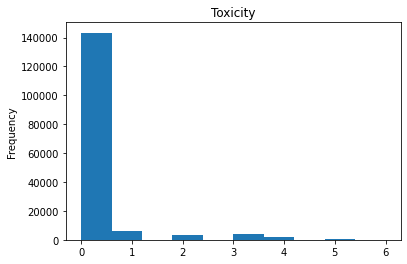

In [9]:
df['toxicity'].plot(kind = 'hist', title = 'Toxicity')

In [10]:
train_df, remaining = train_test_split(df, random_state = 42, train_size = .8, stratify = df['toxicity'].values)
valid_df, _ = train_test_split(remaining, random_state = 42, train_size = .2, stratify = remaining['toxicity'].values)

In [11]:
print(f'remaining shape: {remaining.shape}')
print(f'training shape: {train_df.shape}')
print(f'validation shape: {valid_df.shape}')

remaining shape: (31915, 2)
training shape: (127656, 2)
validation shape: (6383, 2)


In [12]:
df['toxicity'].unique()

array([0., 4., 1., 3., 2., 5., 6.])

In [13]:
with tf.device('/cpu:0'):
    train_data = tf.data.Dataset.from_tensor_slices((train_df['comment_text'].values, train_df['toxicity'].values))
    valid_data= tf.data.Dataset.from_tensor_slices((valid_df['comment_text'].values, valid_df['toxicity'].values))
   
#print one pair in tensorflow dataset to "take" a look at 
for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'comment signed by jackthomas', shape=(), dtype=string)
tf.Tensor(0.0, shape=(), dtype=float64)


In [14]:
label_list =[0,1,2,3,4, 5,6]
max_seq_length = 128


# Get BERT layer and tokenizer:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

#FullTokenizer from BERT handles all the preprocessing of incoming raw text data
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



In [15]:
# This provides a function to convert row to input features and label
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  
  #input example used by BERT
  example = classifier_data_lib.InputExample(guid = None, text_a = text.numpy(),
                                             text_b = None, 
                                             label = label.numpy())
  
  feature = classifier_data_lib.convert_single_example(0,example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [16]:
 def to_feature_map(text, label):
  #wrapping to_feature function, input is text, label, tensor output is int32 -create one for each
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp = [text, label], Tout = [tf.int32,tf.int32, tf.int32, tf.int32])

  #create padding for constant sequence length
  input_ids.set_shape(max_seq_length)
  input_mask.set_shape(max_seq_length)
  segment_ids.set_shape(max_seq_length)
  label_id.set_shape([]) #can leave blank

  #bundle features into dictionary
  x = { 'input_word_ids': input_ids,
       'input_mask': input_mask,
       'input_type_ids': segment_ids
       }
  
  return (x, label_id)


In [17]:
with tf.device('/cpu:0'):
  
  train_data = (train_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE).shuffle(1000)
  .batch(16, drop_remainder = True)
  .prefetch(tf.data.experimental.AUTOTUNE))


  valid_data = (valid_data.map(to_feature_map, num_parallel_calls = tf.data.experimental.AUTOTUNE)
  .batch(16, drop_remainder = True)
  .prefetch( tf.data.experimental.AUTOTUNE))
  
  

In [18]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [19]:
valid_data.element_spec

({'input_mask': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None),
  'input_word_ids': TensorSpec(shape=(16, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16,), dtype=tf.int32, name=None))

In [20]:
#documentation
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  #segment_id from doc
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output) #hyperparameter, add dropout regularization
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(drop) # sigmoid for probability
  model = tf.keras.Model(
     inputs ={
         'input_word_ids': input_word_ids,
       'input_mask': input_mask,
       'input_type_ids': input_type_ids
       },
       outputs = output)
  return model

In [21]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
checkpoint_path = F"'/content/gdrive/My Drive/tfmodel"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [cp_callback]

In [23]:
model = create_model()

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics =[tf.keras.metrics.BinaryAccuracy()] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

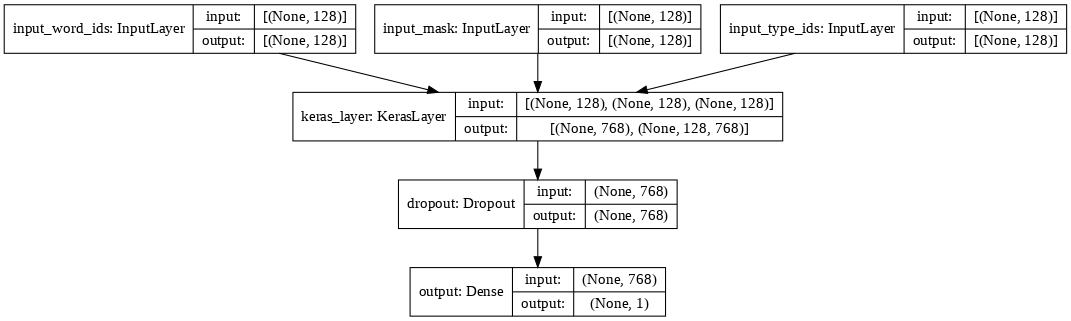

In [24]:
tf.keras.utils.plot_model(model = model, show_shapes=True, dpi = 76)

In [25]:
model.fit(train_data, validation_data= valid_data, epochs = 3, verbose =1, callbacks = callbacks_list)

Epoch 1/3
7978/7978 [==============================] - 3473s 434ms/step - loss: -3.9956 - binary_accuracy: 0.8895 - val_loss: -8.2800 - val_binary_accuracy: 0.8981

Epoch 00001: saving model to '/content/gdrive/My Drive/tfmodel
Epoch 2/3
7978/7978 [==============================] - 3459s 433ms/step - loss: -9.1459 - binary_accuracy: 0.8685 - val_loss: -11.9819 - val_binary_accuracy: 0.8937

Epoch 00002: saving model to '/content/gdrive/My Drive/tfmodel
Epoch 3/3
7978/7978 [==============================] - 3457s 433ms/step - loss: -14.0495 - binary_accuracy: 0.8690 - val_loss: -18.8502 - val_binary_accuracy: 0.9019

Epoch 00003: saving model to '/content/gdrive/My Drive/tfmodel


In [52]:
model.load_weights(checkpoint_path)

In [64]:
model.save('tf_model.h5')
toxic_model = model.save('toxic_model.h5')

In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [78]:
sample_example =['i hate you', 'i love you', 'man fuck you dude', 'what is up with you']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0] *len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
scores =model.predict(test_data, callbacks=callbacks_list)

In [80]:
scores

array([[1.0000000e+00],
       [7.2703534e-04],
       [1.0000000e+00],
       [7.2565372e-04]], dtype=float32)

In [82]:
model.metrics

In [84]:
tf.print(model.weights)

[[[-0.0101825735 -0.0615488291 -0.0264968891 ... -0.0198535696 -0.037209969 -0.00975151826]
 [-0.0117049497 -0.0600260347 -0.0323319174 ... -0.0168145634 -0.0400998816 -0.0106633976]
 [-0.0197538082 -0.0627363324 -0.0326217562 ... -0.0165025778 -0.0419887602 -0.00323178153]
 ...
 [-0.0217622444 -0.0556396022 -0.0134634525 ... -0.00432697684 -0.0151355024 -0.0248949565]
 [-0.0461723693 -0.0564772114 -0.00192082045 ... 0.0156875085 -0.0138703277 -0.00945213344]
 [0.00145601062 -0.0820805058 -0.0159791242 ... -0.00811686646 -0.0474660695 0.0752742067]],
 [[0.0191264059 -0.0282377917 -0.0361825265 ... 0.00146467134 -0.00184680289 0.0180608165]
 [0.00606357632 0.00153708237 -0.0223348439 ... 0.0294282231 0.0275652371 -0.00485812826]
 [-0.0116569679 -0.00206675753 -0.010243237 ... 0.0157354809 0.0152211236 -0.00516175758]
 ...
 [0.0174179319 0.00349026942 -0.00956213754 ... 0.00295993267 0.000434346526 -0.0269489102]
 [0.0216866639 -0.00602163374 0.0147356419 ... -0.00561184 -0.0125897992 -0

In [69]:
from keras.models import load_model

In [73]:
from tensorflow.keras.models import model_from_json

import tensorflow_hub as hub

with open('models.json', 'r') as f: 
  json = model.read() 
loaded_model = model_from_json(json, custom_objects={'KerasLayer': hub.KerasLayer})

FileNotFoundError: ignored

In [72]:
new_model = load_model('tf_model.h5')

ValueError: ignored

In [66]:
PATH =F"'/content/gdrive/MyDrive/torchmodel.pt"
torch.save(model.state_dict())

AttributeError: ignored

In [28]:
import matplotlib.pyplot as plt

def plot_graphs(model, metric):
  plt.plot(model.model[metric])
  plt.plot(model.model['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()


In [50]:
print(callbacks_list)

In [39]:
new_model =model.load_weights(F"'/content/gdrive/My Drive/tfmodel")

In [41]:
sample_example =
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0] *len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = new_model.predict(test_data)
threshold = .1 #between 0 and 1

AttributeError: ignored

In [49]:
sample_example =[ 'Are you ok', 'Fuck off']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0] *len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
loss,acc = new_model.evaluate(test_data)


AttributeError: ignored